In [1]:
import gym

In [4]:
a = np.array([0,1,2])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1


In [5]:
import time

In [6]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [7]:
env =simple_spread_v1.parallel_env(max_frames=100)


In [8]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [9]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_actions = network_config.get("num_actions")
        self.step_size=network_config.get('step_size')
    def create_model(self):
        i = Input(shape=self.state_dim)
        x = Dense(256, activation='relu')(i)
        x = Dense(128, activation='relu')(x)
        x = Dense(self.num_actions, activation='linear')(x)
        model = Model(i, x)
        model.compile(optimizer=Adam(lr=self.step_size),loss='mse')
        return model

In [10]:
epsilon = 1  
EPSILON_DECAY = 0.998 
MIN_EPSILON = 0.01
    

In [11]:
agent_info = {
             'network_config': {
                 'state_dim': 21,
                 'num_actions': 5,
                 'step_size':1e-4
             },
             'replay_buffer_size': 256,
             'minibatch_sz': 32,
             'num_replay_updates_per_step': 3,
             'gamma': 0.99,
             'seed': 0}

In [12]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
       
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
     
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
       
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [16]:
class Agent:
    def __init__(self, agent_config):
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        
        self.model=self.network.create_model()
        
        self.target_model=self.network.create_model()
        
        self.num_actions = agent_config['network_config']['num_actions']
        
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        self.last_states = None
        self.actions = None
        self.epsilon = epsilon
        self.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
        self.episode_steps = 0
    def policy(self,agent,state):
        action_values =self.model.predict(state)
        if (np.random.uniform() < self.epsilon):
            action = np.random.randint(0, env.action_spaces[agent].n)
        else:
            action=np.argmax(action_values)
        return int(action)
    def agent_start(self):
        self.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
        self.episode_steps=0
        self.last_states=env.reset()
        for i,m in enumerate(self.last_states.keys()):
            self.last_states[m]=np.array([np.append(self.last_states[m],b[i])])
        self.actions = {agent: self.policy(agent,self.last_states[agent]) for agent in env.agents}
        actions=self.actions
        return actions
    
    def agent_step(self,states,rewards,terminals):
        self.sum_rewards={agent: (self.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        self.episode_steps += 1
        for i,m in enumerate(states.keys()):
            states[m]=np.array([np.append(states[m],b[i])])
        
        for agent in states:
            state=states[agent]
            last_state=self.last_states[agent]
            action=self.actions[agent]
            reward=rewards[agent]
            terminal=terminals[agent]
            self.replay_buffer.append(last_state,action, reward, terminal, state)
        
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            self.target_model.set_weights(self.model.get_weights())
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                self.agent_train(experiences)
        
        
      
        self.last_states=states
        self.actions = {agent: self.policy(agent,self.last_states[agent]) for agent in env.agents}
        actions=self.actions
        return actions
    
    def agent_train(self,experiences):
        
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        rewards = np.array(rewards)
        terminals = np.array(terminals)
        batch_size1 = states.shape[0]
        q_next_mat = self.target_model.predict(next_states)
        
        v_next_vec = np.max(q_next_mat, axis=1)*(1-terminals)
        
        target_vec = rewards + self.discount*v_next_vec
       
        q_mat = self.model.predict(states)
      
        batch_indices = np.arange(q_mat.shape[0])

        X=states
        q_mat[batch_indices,actions] = target_vec
 
        self.model.fit(X,q_mat,batch_size=batch_size1,verbose=0,shuffle=False)

In [17]:
dqn=Agent(agent_info)

In [18]:
episode_rewards=[]
episode_steps=[]
episode_epsilon=[]

In [19]:
for episode in range(0,1000):
    actions=dqn.agent_start()
    
    for step in range(100):
        next_states, rewards, dones, infos = env.step(actions)
        terminals={agent: 1 if dones[agent] ==True else 0 for agent in dones}
        actions=dqn.agent_step(next_states,rewards,dones)
        if dqn.epsilon > MIN_EPSILON:
            dqn.epsilon *= EPSILON_DECAY
            dqn.epsilon = max(MIN_EPSILON,dqn.epsilon)
    print("EPISODE",episode," Epsilon = ",dqn.epsilon," STEPS = ",dqn.episode_steps)
    print("REWARD",dqn.sum_rewards)
    episode_rewards.append(dqn.sum_rewards)
    episode_steps.append(dqn.episode_steps)
    episode_epsilon.append(dqn.epsilon)
    


EPISODE 0  Epsilon =  0.818566804688428  STEPS =  100
REWARD {'agent_0': -197.24030902635292, 'agent_1': -197.24030902635292, 'agent_2': -197.24030902635292}
EPISODE 1  Epsilon =  0.670051613737823  STEPS =  100
REWARD {'agent_0': -191.3327651552642, 'agent_1': -190.3327651552642, 'agent_2': -191.8327651552642}
EPISODE 2  Epsilon =  0.5484820084336942  STEPS =  100
REWARD {'agent_0': -167.5666886173833, 'agent_1': -165.06668861738333, 'agent_2': -168.5666886173833}
EPISODE 3  Epsilon =  0.4489691650726603  STEPS =  100
REWARD {'agent_0': -184.56906395818203, 'agent_1': -183.06906395818203, 'agent_2': -182.56906395818203}
EPISODE 4  Epsilon =  0.36751125485715885  STEPS =  100
REWARD {'agent_0': -144.56324607822884, 'agent_1': -144.06324607822884, 'agent_2': -139.56324607822887}
EPISODE 5  Epsilon =  0.3008325135754587  STEPS =  100
REWARD {'agent_0': -135.84679429410787, 'agent_1': -131.84679429410784, 'agent_2': -143.34679429410784}
EPISODE 6  Epsilon =  0.24625150938385126  STEPS =  

EPISODE 55  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -165.3677298144847, 'agent_1': -172.86772981448473, 'agent_2': -167.8677298144847}
EPISODE 56  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -148.94031162837976, 'agent_1': -160.44031162837976, 'agent_2': -145.4403116283798}
EPISODE 57  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -152.7046266439323, 'agent_1': -157.20462664393224, 'agent_2': -154.70462664393224}
EPISODE 58  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -103.6344102210328, 'agent_1': -103.6344102210328, 'agent_2': -103.1344102210328}
EPISODE 59  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -137.29516947550917, 'agent_1': -146.7951694755092, 'agent_2': -142.29516947550917}
EPISODE 60  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -155.95797417747983, 'agent_1': -162.95797417747983, 'agent_2': -152.45797417747985}
EPISODE 61  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -123.11275629837303, 'agent_1': -124.11275629837303, 'agent_2': -124.11

EPISODE 112  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -152.74161020973716, 'agent_1': -152.74161020973716, 'agent_2': -152.74161020973716}
EPISODE 113  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -133.46153176149045, 'agent_1': -133.46153176149045, 'agent_2': -133.46153176149045}
EPISODE 114  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -155.8733563679368, 'agent_1': -155.8733563679368, 'agent_2': -155.8733563679368}
EPISODE 115  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -111.0297832120634, 'agent_1': -109.5297832120634, 'agent_2': -111.0297832120634}
EPISODE 116  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -121.09440601037227, 'agent_1': -117.59440601037227, 'agent_2': -116.09440601037227}
EPISODE 117  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -102.56545680491273, 'agent_1': -102.56545680491273, 'agent_2': -101.56545680491273}
EPISODE 118  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -111.67902076859983, 'agent_1': -111.67902076859983, 'agent_2'

EPISODE 169  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -114.52364148753584, 'agent_1': -114.02364148753583, 'agent_2': -115.52364148753584}
EPISODE 170  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -182.98292699319381, 'agent_1': -183.9829269931938, 'agent_2': -182.48292699319381}
EPISODE 171  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -148.64559804975792, 'agent_1': -156.64559804975795, 'agent_2': -153.64559804975792}
EPISODE 172  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -107.3600656737412, 'agent_1': -107.3600656737412, 'agent_2': -107.3600656737412}
EPISODE 173  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -150.33018044143822, 'agent_1': -148.83018044143822, 'agent_2': -151.83018044143822}
EPISODE 174  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -99.6395653458832, 'agent_1': -99.6395653458832, 'agent_2': -99.6395653458832}
EPISODE 175  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -109.61929054972173, 'agent_1': -109.61929054972173, 'agent_2': -1

EPISODE 226  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -155.5864810703786, 'agent_1': -155.08648107037862, 'agent_2': -155.5864810703786}
EPISODE 227  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -150.84361156336468, 'agent_1': -150.84361156336468, 'agent_2': -150.84361156336468}
EPISODE 228  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -120.91489544652518, 'agent_1': -119.41489544652518, 'agent_2': -117.41489544652518}
EPISODE 229  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -130.770366338191, 'agent_1': -134.270366338191, 'agent_2': -134.270366338191}
EPISODE 230  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -126.51168244799926, 'agent_1': -126.51168244799926, 'agent_2': -126.51168244799926}
EPISODE 231  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -126.7923608854144, 'agent_1': -119.2923608854144, 'agent_2': -123.2923608854144}
EPISODE 232  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -127.74292282801355, 'agent_1': -128.24292282801355, 'agent_2': -12

EPISODE 283  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -108.76038113360279, 'agent_1': -108.76038113360279, 'agent_2': -109.26038113360279}
EPISODE 284  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -117.75314270831531, 'agent_1': -117.75314270831531, 'agent_2': -117.75314270831531}
EPISODE 285  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -121.36496712355537, 'agent_1': -121.86496712355537, 'agent_2': -121.86496712355537}
EPISODE 286  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -121.4697442367082, 'agent_1': -122.4697442367082, 'agent_2': -115.4697442367082}
EPISODE 287  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -106.67981331780018, 'agent_1': -106.67981331780018, 'agent_2': -106.67981331780018}
EPISODE 288  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -128.86037229276224, 'agent_1': -127.86037229276224, 'agent_2': -127.86037229276224}
EPISODE 289  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -147.99273178661323, 'agent_1': -144.99273178661318, 'agent

EPISODE 340  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -124.3145823322894, 'agent_1': -124.3145823322894, 'agent_2': -113.81458233228938}
EPISODE 341  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -132.90050174109965, 'agent_1': -139.40050174109962, 'agent_2': -139.40050174109962}
EPISODE 342  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -121.56945823908677, 'agent_1': -121.56945823908677, 'agent_2': -121.56945823908677}
EPISODE 343  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -140.41039042524818, 'agent_1': -140.41039042524818, 'agent_2': -139.91039042524818}
EPISODE 344  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -143.6174380281839, 'agent_1': -143.11743802818387, 'agent_2': -143.1174380281839}
EPISODE 345  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -150.21806348884036, 'agent_1': -150.71806348884036, 'agent_2': -150.21806348884036}
EPISODE 346  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -125.9151041052896, 'agent_1': -125.9151041052896, 'agent_2'

EPISODE 397  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -119.38686658211306, 'agent_1': -119.38686658211306, 'agent_2': -116.88686658211306}
EPISODE 398  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -89.3502972773002, 'agent_1': -89.3502972773002, 'agent_2': -87.8502972773002}
EPISODE 399  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -157.77048519948522, 'agent_1': -164.77048519948517, 'agent_2': -165.27048519948517}
EPISODE 400  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -136.01009107220474, 'agent_1': -138.01009107220474, 'agent_2': -136.01009107220474}
EPISODE 401  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -85.27103743073191, 'agent_1': -85.27103743073191, 'agent_2': -85.27103743073191}
EPISODE 402  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -177.61204989680965, 'agent_1': -173.11204989680965, 'agent_2': -177.61204989680965}
EPISODE 403  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -111.75417715915393, 'agent_1': -111.75417715915393, 'agent_2': -

EPISODE 454  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -165.923488830041, 'agent_1': -165.923488830041, 'agent_2': -165.923488830041}
EPISODE 455  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -94.70366368601147, 'agent_1': -94.70366368601147, 'agent_2': -94.70366368601147}
EPISODE 456  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -157.20827318418017, 'agent_1': -159.20827318418017, 'agent_2': -163.70827318418017}
EPISODE 457  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -160.17630185620914, 'agent_1': -162.67630185620914, 'agent_2': -162.67630185620914}
EPISODE 458  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -130.92512872291482, 'agent_1': -130.42512872291482, 'agent_2': -135.92512872291482}
EPISODE 459  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -116.33401373670253, 'agent_1': -116.33401373670253, 'agent_2': -116.83401373670253}
EPISODE 460  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -139.9508700588564, 'agent_1': -135.95087005885637, 'agent_2': -1

EPISODE 511  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -145.2557600277791, 'agent_1': -151.7557600277791, 'agent_2': -151.7557600277791}
EPISODE 512  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -139.132361517316, 'agent_1': -135.13236151731604, 'agent_2': -139.132361517316}
EPISODE 513  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -142.49870052958326, 'agent_1': -142.49870052958326, 'agent_2': -142.49870052958326}
EPISODE 514  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -129.26539727127428, 'agent_1': -127.76539727127427, 'agent_2': -131.26539727127425}
EPISODE 515  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -87.04702335740323, 'agent_1': -87.04702335740323, 'agent_2': -87.04702335740323}
EPISODE 516  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -99.83299317362535, 'agent_1': -99.83299317362535, 'agent_2': -99.83299317362535}
EPISODE 517  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -160.25771813559, 'agent_1': -159.25771813559, 'agent_2': -161.257718

EPISODE 568  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -130.64064982195518, 'agent_1': -130.64064982195518, 'agent_2': -130.64064982195518}
EPISODE 569  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -167.091730102574, 'agent_1': -166.591730102574, 'agent_2': -166.09173010257396}
EPISODE 570  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -135.2613285561627, 'agent_1': -135.2613285561627, 'agent_2': -135.2613285561627}
EPISODE 571  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -136.90024782659913, 'agent_1': -137.40024782659913, 'agent_2': -137.40024782659913}
EPISODE 572  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -165.98099968027137, 'agent_1': -172.4809996802714, 'agent_2': -171.4809996802714}
EPISODE 573  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -88.62013681870432, 'agent_1': -88.62013681870432, 'agent_2': -88.62013681870432}
EPISODE 574  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -117.41875039462461, 'agent_1': -116.91875039462461, 'agent_2': -119

EPISODE 625  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -136.91021832174675, 'agent_1': -139.41021832174673, 'agent_2': -144.9102183217467}
EPISODE 626  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -175.62169537199514, 'agent_1': -175.62169537199514, 'agent_2': -174.62169537199514}
EPISODE 627  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -100.56329792383995, 'agent_1': -97.56329792383997, 'agent_2': -101.06329792383997}
EPISODE 628  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -120.39845393111436, 'agent_1': -116.89845393111436, 'agent_2': -119.39845393111436}
EPISODE 629  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -132.44392123517656, 'agent_1': -136.94392123517662, 'agent_2': -135.9439212351766}
EPISODE 630  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -132.83495426691792, 'agent_1': -132.83495426691792, 'agent_2': -132.83495426691792}
EPISODE 631  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -98.5289395477348, 'agent_1': -97.52893954773478, 'agent_2'

EPISODE 682  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -216.06933951878824, 'agent_1': -213.56933951878824, 'agent_2': -215.06933951878824}
EPISODE 683  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -167.0598584562164, 'agent_1': -169.5598584562164, 'agent_2': -169.5598584562164}
EPISODE 684  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -146.75372146308237, 'agent_1': -146.25372146308237, 'agent_2': -146.75372146308237}
EPISODE 685  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -171.04786772447392, 'agent_1': -179.0478677244739, 'agent_2': -181.0478677244739}
EPISODE 686  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -116.776420984635, 'agent_1': -123.276420984635, 'agent_2': -120.276420984635}
EPISODE 687  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -165.3299823297546, 'agent_1': -168.8299823297546, 'agent_2': -165.3299823297546}
EPISODE 688  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -147.5277257650881, 'agent_1': -157.52772576508806, 'agent_2': -158.52

EPISODE 739  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -122.04516683287378, 'agent_1': -122.54516683287378, 'agent_2': -120.04516683287378}
EPISODE 740  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -102.41285292939742, 'agent_1': -101.91285292939742, 'agent_2': -100.91285292939742}
EPISODE 741  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -146.5525995699244, 'agent_1': -144.0525995699244, 'agent_2': -143.0525995699244}
EPISODE 742  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -158.86525227802395, 'agent_1': -158.86525227802395, 'agent_2': -158.86525227802395}
EPISODE 743  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -120.9950239461137, 'agent_1': -119.4950239461137, 'agent_2': -120.9950239461137}
EPISODE 744  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -107.73039918765011, 'agent_1': -107.73039918765011, 'agent_2': -107.73039918765011}
EPISODE 745  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -142.26470802738305, 'agent_1': -142.26470802738305, 'agent_2'

EPISODE 796  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -113.66947654763322, 'agent_1': -113.66947654763322, 'agent_2': -116.1694765476332}
EPISODE 797  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -173.20779810457466, 'agent_1': -172.20779810457466, 'agent_2': -164.70779810457464}
EPISODE 798  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -126.72079018833107, 'agent_1': -126.72079018833107, 'agent_2': -126.72079018833107}
EPISODE 799  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -117.25343959266418, 'agent_1': -117.25343959266418, 'agent_2': -112.25343959266415}
EPISODE 800  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -115.56710871608267, 'agent_1': -117.56710871608267, 'agent_2': -119.06710871608267}
EPISODE 801  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -121.55639791575095, 'agent_1': -121.55639791575095, 'agent_2': -118.05639791575095}
EPISODE 802  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -167.1470948101007, 'agent_1': -167.6470948101007, 'agent

EPISODE 853  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -111.84680189893784, 'agent_1': -111.84680189893784, 'agent_2': -110.34680189893784}
EPISODE 854  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -133.58875609844324, 'agent_1': -133.58875609844324, 'agent_2': -133.58875609844324}
EPISODE 855  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -138.33443424263476, 'agent_1': -137.83443424263476, 'agent_2': -136.33443424263473}
EPISODE 856  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -123.42719747267603, 'agent_1': -123.42719747267603, 'agent_2': -123.42719747267603}
EPISODE 857  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -150.88754397877997, 'agent_1': -150.88754397877997, 'agent_2': -149.88754397877997}
EPISODE 858  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -191.6348268229333, 'agent_1': -191.6348268229333, 'agent_2': -185.1348268229333}
EPISODE 859  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -128.32051283654852, 'agent_1': -128.32051283654852, 'agent

EPISODE 910  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -125.88536552645076, 'agent_1': -125.88536552645076, 'agent_2': -119.88536552645076}
EPISODE 911  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -105.78571441104016, 'agent_1': -105.78571441104016, 'agent_2': -104.28571441104016}
EPISODE 912  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -131.07286665797116, 'agent_1': -131.07286665797116, 'agent_2': -129.07286665797116}
EPISODE 913  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -157.01286211183094, 'agent_1': -157.01286211183094, 'agent_2': -157.01286211183094}
EPISODE 914  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -94.26319810455459, 'agent_1': -94.26319810455459, 'agent_2': -91.76319810455458}
EPISODE 915  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -128.46300884847724, 'agent_1': -129.46300884847724, 'agent_2': -129.46300884847724}
EPISODE 916  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -134.07249865159946, 'agent_1': -133.57249865159946, 'agent

EPISODE 967  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -134.4617912017066, 'agent_1': -134.4617912017066, 'agent_2': -134.4617912017066}
EPISODE 968  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -141.38023164587716, 'agent_1': -141.38023164587716, 'agent_2': -141.38023164587716}
EPISODE 969  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -142.36993697186855, 'agent_1': -142.36993697186855, 'agent_2': -142.36993697186855}
EPISODE 970  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -130.78419222538682, 'agent_1': -130.78419222538682, 'agent_2': -130.78419222538682}
EPISODE 971  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -136.58632225501543, 'agent_1': -135.5863222550154, 'agent_2': -134.58632225501543}
EPISODE 972  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -156.27480551595673, 'agent_1': -155.27480551595676, 'agent_2': -156.27480551595673}
EPISODE 973  Epsilon =  0.01  STEPS =  100
REWARD {'agent_0': -149.65117663123075, 'agent_1': -148.15117663123075, 'agent_

In [21]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [22]:
for m in episode_rewards:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [23]:
for i in range(0,1000):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [24]:
for i in range(0,1000):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [25]:
for i in range(0,1000):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [26]:
import matplotlib.pyplot as plt

In [27]:
no_episodes=[]
for i in range(0,1000):
    no_episodes.append(i)

In [28]:
len(no_episodes)

1000

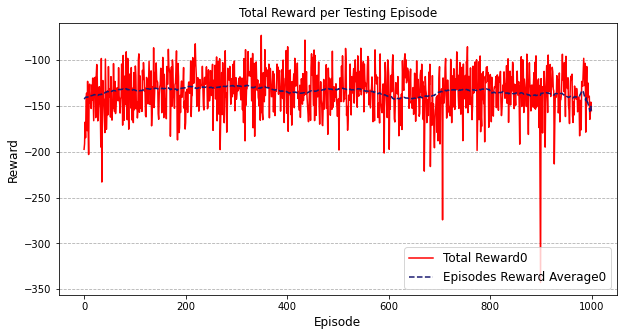

In [29]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [88]:
np.mean(rewards_0)+np.mean(rewards_1)+np.mean(rewards_2)

-403.33427464010117

In [90]:
np.mean(rewards_0+rewards_1+rewards_2)

-134.44475821336707

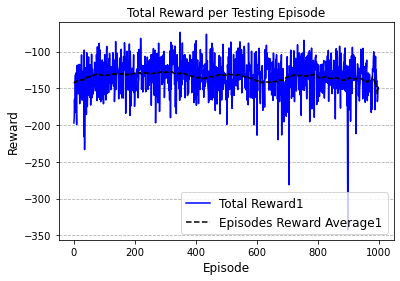

In [91]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()


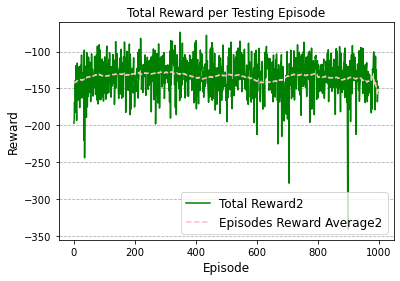

In [92]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

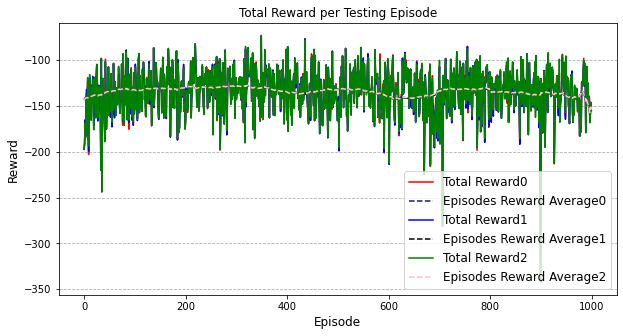

In [96]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')

plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [117]:
total_avg_reward=[]

In [118]:
for i in range(0,1000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [119]:
avg_total=[]

In [120]:
for i in range(0,1000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

In [124]:
r

-403.33427

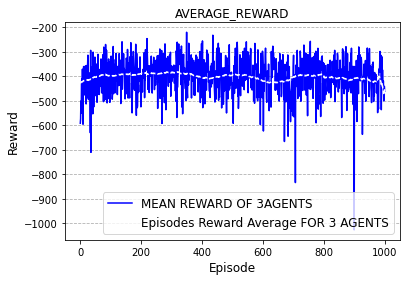

In [127]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [33]:
dqn.model.save('Single_dqn.h5')

In [34]:
from tensorflow.keras.models import load_model

In [35]:
model=load_model('Single_dqn.h5')